## 2

### a.

In [25]:
import numpy as np


def binomial_tree_discrete_dividends(
    S: float,
    K: float,
    T: float,
    r: float,
    sigma: float,
    q: float,
    div_times: list[float],
    div_amounts: list[float],
    option_type: str,
    style: str,
    n: int,
):
    """
    Calculates the price of an option (European or American, call or put)
    using a binomial tree model, considering discrete dividends.

    Args:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (continuously compounded).
        sigma (float): Volatility of the stock.
        q (float): Continuous dividend yield.  This is used for the *prepaid forward* volatility adjustment, and only applies *before* the discrete dividends.
        div_times (list): List of times (in years) when dividends are paid.
        div_amounts (list): List of dividend amounts paid at the corresponding div_times.
        option_type (str): 'call' or 'put'.
        style (str): 'european' or 'american'.
        n (int): Number of time steps in the binomial tree.
    """
    # Input validation
    if option_type.lower() not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'")
    if style.lower() not in ("european", "american"):
        raise ValueError("style must be 'european' or 'american'")
    if len(div_times) != len(div_amounts):
        raise ValueError("div_times and div_amounts must have the same length")
    if any(t > T for t in div_times):
        raise ValueError("Dividend times cannot be greater than the time to maturity")
    if n <= 0:
        raise ValueError("Number of steps 'n' must be a positive integer.")

    dt = T / n  # Length of each time step

    # 1. Compute PV of dividends & prepaid forward price
    pv_dividends = sum(div * np.exp(-r * t) for t, div in zip(div_times, div_amounts))
    S_prepaid = S - pv_dividends  # Stock price adjusted for dividends

    # 2. calculate u, d and p
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))  # Up factor
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))  # Down factor
    p = (np.exp((r - q) * dt) - d) / (u - d)  # Risk-neutral probability

    if not (0 <= p <= 1):
        raise ValueError(
            "Arbitrage opportunity detected (risk-neutral probability is not between 0 and 1).  Check your parameters."
        )

    # 3. Build stock and option trees
    stock_tree = np.zeros((n + 1, n + 1))  # Initialize stock price tree
    stock_tree[0, 0] = S_prepaid  # Initial stock price

    for div_time, div_amount in zip(div_times, div_amounts):
        if div_time < dt:
            stock_tree[0, 0] += div_amount  # Add dividend if paid at this time
        elif div_time >= dt:
            stock_tree[0, 0] += div_amount * np.exp(-r * div_time)  # Discounted dividend
    
    for i in range(1, n + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S_prepaid * (u ** (i - j)) * (d**j)  # Stock price at node (i, j)
            for div_time, div_amount in zip(div_times, div_amounts):
                if div_time < (i + 1) * dt and div_time >= i * dt:
                    stock_tree[j, i] += div_amount  # Add dividend if paid at this time

                elif div_time >= (i + 1) * dt:
                    stock_tree[j, i] += div_amount * np.exp(-r * (div_time - i * dt)) # Discounted dividend

    option_tree = np.zeros((n + 1, n + 1))  # Initialize option price tree
    for j in range(n + 1):
        if option_type.lower() == "call":
            option_tree[j, n] = max(0, stock_tree[j, n] - K)  # Call option payoff at expiration
        else:  # put
            option_tree[j, n] = max(0, K - stock_tree[j, n])  # Put option payoff at expiration

    # 4. Work backwards through the tree
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            european_value = np.exp(-r * dt) * (
                p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1]
            )  # Expected option value

            if (
                style.lower() == "american"
            ):  # 5. The price is calculated differently for American options
                if option_type.lower() == "call":
                    intrinsic_value = max(0, stock_tree[j, i] - K)  # Call option intrinsic value
                else:
                    intrinsic_value = max(0, K - stock_tree[j, i])  # Put option intrinsic value
                option_tree[j, i] = max(european_value, intrinsic_value)  # Option value is max of intrinsic and expected
            else:
                option_tree[j, i] = european_value  # European option value

    return option_tree[0, 0], stock_tree, option_tree  # Return option price

In [28]:
S = 41  # Current stock price
K = 40  # Strike price
T = 1    # Time to maturity (1 year)
r = 0.08 # Risk-free interest rate
sigma = 0.3392 # Volatility
q = 0    # Continuous dividend yield
div_times = [2/3]  # Dividend times (in years)
div_amounts = [5]  # Dividend amounts
option_type = 'call'      # Option type
style = 'american'   # Option style
n = 3     # Number of steps


option_price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
print(f"American Call Option Price (McDonald Replication, n={n}): {option_price:.3f}")
if np.abs(option_price - 5.770) < 0.001: # 5.770 is the expected result from the book
    print("The result is correct")
else:
    print("The result is incorrect")

American Call Option Price (McDonald Replication, n=3): 5.770
The result is correct


In [29]:
S = 41
K = 40
T = 0.25
r = 0.08
div_times = [1/12]
div_amounts = [3]
sigma = 0.3
option_type = 'call'
style = 'european'
q = 0
n = 900
option_price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
print(f"European Call Option Price (McDonald Replication, n={n}): {option_price:.3f}")
if np.abs(option_price - 1.763) < 0.001: # 1.763 is the expected result from the book
    print("The result is correct")
else:
    print("The result is incorrect")

European Call Option Price (McDonald Replication, n=900): 1.763
The result is correct


### b.

Option price with 5 steps: 4.4079
Option price with 50 steps: 4.2391
Option price with 100 steps: 4.2235


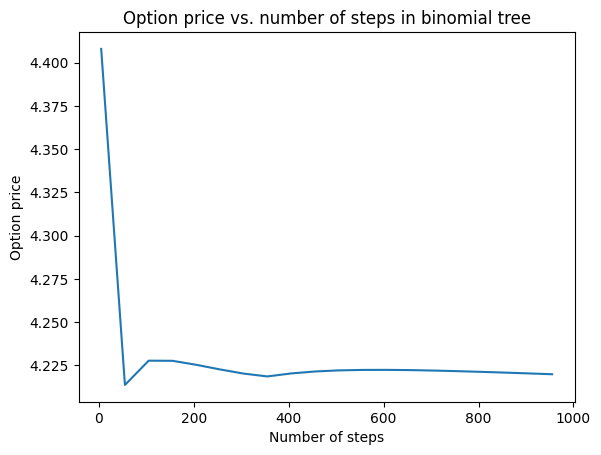

In [30]:
S = 52  # Initial stock price
K = 50  # Strike price
T = 5 / 12  # Time to maturity (5 months)
r = 0.10  # Risk-free interest rate (10% per annum)
sigma = 0.40  # Volatility (40% per annum)
div_times = [3.5 / 12]  # Dividend time (3.5 months)
div_amounts = [2.06]  # Dividend amount
option_type = 'put'  
style = 'american'  
q = 0 # no continuous dividend yield

n_values = [5, 50, 100]
option_prices = []

for n in n_values:
    price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
    option_prices.append(price)
    print(f"Option price with {n} steps: {price:.4f}")


import matplotlib.pyplot as plt

n_values = range(5, 1000, 50)
option_prices = []

for n in n_values:
    price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
    option_prices.append(price)
    
plt.plot(n_values, option_prices)
plt.xlabel("Number of steps")
plt.ylabel("Option price")
plt.title("Option price vs. number of steps in binomial tree")
plt.show()


In [ ]:
import numpy as np

def generate_latex_tree_mcdonald(stock_tree: list[list[float]], option_tree: list[list[float]], n: int):
    """
    Utility function that generates LaTeX code for a binomial tree.
    """

    latex_code = r"""
\begin{tikzpicture}[
    x=1.5cm,  % Horizontal spacing
    y=1.2cm,  % Vertical spacing (positive for upwards growth)
    font=\footnotesize,
    every node/.style={align=center} % Center-align text
]

"""

    for i in range(n + 1):
        for j in range(i + 1):
            node_content = (
                f"${stock_tree[j, i]:.3f}$\\\\"
                f"${option_tree[j, i]:.3f}$"
            )
            y_coord =  (i / 2.0) - j
            latex_code += f"\\node at ({i},{y_coord}) (node{i}{j}) {{{node_content}}};\n"

    for i in range(n + 1):
        for j in range(i + 1):
            if i < n:
                latex_code += f"\\draw (node{i}{j}) -- (node{i+1}{j});\n"
                latex_code += f"\\draw (node{i}{j}) -- (node{i+1}{j+1});\n"

    latex_code += r"""
\end{tikzpicture}
\caption{Binomial tree for the case with 5 time steps}
"""
    return latex_code

price, stock_tree, option_tree = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, 5)
latex_output = generate_latex_tree_mcdonald(stock_tree, option_tree, 5)
print(latex_output)


\begin{tikzpicture}[
    x=1.5cm,  % Horizontal spacing
    y=1.2cm,  % Vertical spacing (positive for upwards growth)
    font=\footnotesize,
    every node/.style={align=center} % Center-align text
]

\node at (0,0.0) (node00) {$52.000$\\$4.408$};
\node at (1,0.5) (node10) {$58.606$\\$2.013$};
\node at (1,-0.5) (node11) {$46.937$\\$6.612$};
\node at (2,1.0) (node20) {$66.081$\\$0.513$};
\node at (2,0.0) (node21) {$52.874$\\$3.381$};
\node at (2,-1.0) (node22) {$42.390$\\$9.595$};
\node at (3,1.5) (node30) {$74.548$\\$0.000$};
\node at (3,0.5) (node31) {$59.600$\\$0.979$};
\node at (3,-0.5) (node32) {$47.734$\\$5.574$};
\node at (3,-1.5) (node33) {$38.316$\\$13.329$};
\node at (4,2.0) (node40) {$82.041$\\$0.000$};
\node at (4,1.0) (node41) {$65.123$\\$0.000$};
\node at (4,0.0) (node42) {$51.694$\\$1.866$};
\node at (4,-1.0) (node43) {$41.034$\\$8.966$};
\node at (4,-2.0) (node44) {$32.572$\\$17.428$};
\node at (5,2.5) (node50) {$92.854$\\$0.000$};
\node at (5,1.5) (node51) {$73.706$\